# Implementation of Perelson et al.

**Please indicate at the top of your assignment whether or not you used any AI tools, such as MS Copilot. If you did use one of these tools, please provide a very brief explanation alongside each answer for how you confirmed the correctness of your solution.**

In this implementation we're going to evaluate the properties of a [dynamical model](https://www.jstor.org/stable/2890727).

No I did not use AI

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, use the fitted parameters and the appropriate constants to generate the curves shown on these plots. Remember to account for the time delays for each patient.

#### (i) Implement eq. 6 from the paper as a function.

In [2]:
# Answer
# parameters c (virionclearance rate), 8 (rate of loss of infected cells), and VO(initialviral load) were simultaneously estimated
def equation_6(tps: np.ndarray, v0: float, c: float, delta: float, delay: float, scale: float=1.0):
    """It may help to structure your equation with these inputs,
    and output an array of predictions over time."""
    
    v0_delay = np.repeat(v0, int(delay*24))
    tps_adj = tps[:-int(delay*24)].copy()
    vt = np.append(v0_delay, v0 * np.exp(-c*tps_adj) + c*v0 / (c-delta) * (c/(c-delta) * (np.exp(-delta*tps_adj) - np.exp(-c*tps_adj)) - delta * tps_adj * np.exp(-c*tps_adj)))
    
    vi = v0_delay
    vi_last = v0
    for t in tps_adj: 
        vi_last -= c/24*vi_last #adjust c rate to per hour
        vi = np.append(vi,vi_last)
        
#     vi = np.append(v0_delay,-c * v0 * tps_adj)
    
#   vt is sum of vi + vni
    vni = vt - vi
    
    vt *= scale
    vi *= scale
    vni *= scale
    
    return vt, vi, vni

#### (ii) Make the figure panels from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in Wein et al. (J. Theor. Biol. 192:81-98) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for $T^*$, $V_I$, and $V_{NI}$ to reproduce the data in Figure 1.

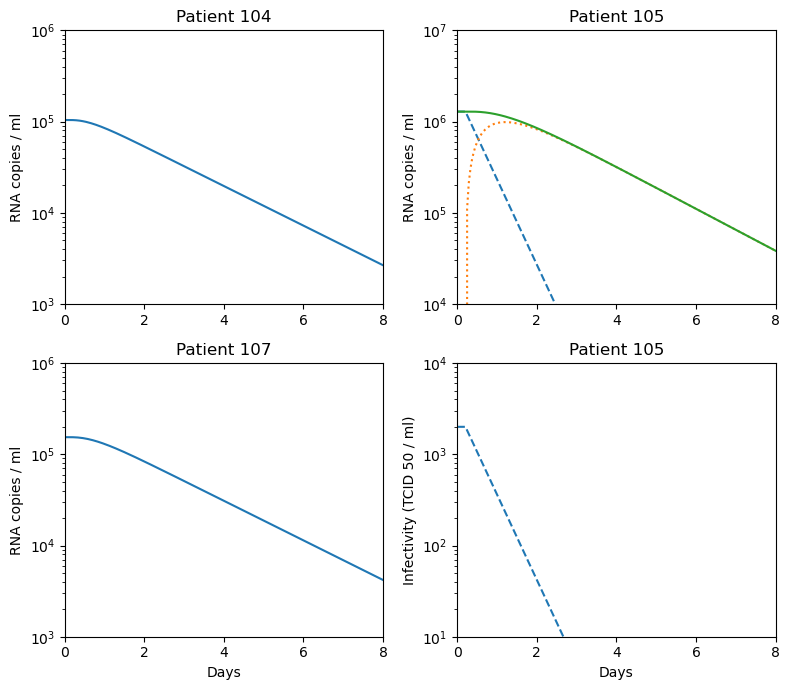

In [3]:
# Answer
# 24 hours for 8 days
days_array = np.arange(0, 8+1/24, 1/24, dtype=float)


fig, axes = plt.subplots(2,2, figsize=(8,7))

# ================= A =====================
# patient 104
vt, vi, vni = equation_6(tps=days_array, 
           v0=52e3, 
           c=3.68, 
           delta = 0.50, 
           delay = 2/24,
            scale = 2)

axes[0][0].plot(days_array,vt)

axes[0][0].set_yscale('log')
axes[0][0].set_xlim(days_array.min(), days_array.max())
axes[0][0].set_ylim(bottom=1e3, top=1e6)

axes[0][0].set_title("Patient 104")
axes[0][0].set_ylabel("RNA copies / ml")

# patient 107
vt, vi, vni = equation_6(tps=days_array, 
           v0=77e3, 
           c=3.09, 
           delta = 0.50, 
           delay = 2/24,
            scale = 2)

axes[1][0].plot(days_array,vt)

axes[1][0].set_yscale('log')
axes[1][0].set_xlim(days_array.min(), days_array.max())
axes[1][0].set_ylim(bottom=1e3, top=1e6)

axes[1][0].set_title("Patient 107")
axes[1][0].set_xlabel("Days")
axes[1][0].set_ylabel("RNA copies / ml")


# ================= B =====================
# patient 105
vt, vi, vni = equation_6(tps=days_array, 
           v0=643e3, 
           c=2.06, 
           delta = 0.53, 
           delay = 6/24,
           scale = 2)


axes[0][1].plot(days_array,vi, "--")
axes[0][1].plot(days_array,vni, ":")
axes[0][1].plot(days_array,vt)

axes[0][1].set_yscale('log')
axes[0][1].set_xlim(days_array.min(), days_array.max())
axes[0][1].set_ylim(bottom=1e4, top=1e7)

axes[0][1].set_title("Patient 105")
axes[0][1].set_ylabel("RNA copies / ml")

patient_vi_t0 = vi[0]
patient_vni_t0 = vni[0]

# patient 105
vt, vi, vni = equation_6(tps=days_array, 
           v0=1e3, 
           c=2.06, 
           delta = 0.53, 
           delay = 6/24,
           scale = 2)

# axes[1][1].plot(days_array,vt, "--")
axes[1][1].plot(days_array,vi, "--")
# axes[1][1].plot(days_array,vni, "--")
axes[1][1].set_yscale('log')

axes[1][1].set_xlim(days_array.min(), days_array.max())
axes[1][1].set_ylim(bottom=10, top=1e4)
axes[1][1].set_xlabel("Days")
axes[1][1].set_ylabel("Infectivity (TCID 50 / ml)")
axes[1][1].set_title("Patient 105")

plt.tight_layout()

### (2) Can the ODE model of virion production before treatment show stable or unstable oscillations?

Describe and justify your answer.

In [6]:
# Define the system of ODEs
def system(t, z, p):
    V,T_star = z
    k,T,delta,N,c= p
    dTstar_dt = k * V * T - delta * T_star
    dVdt = N * delta * T_star - c * V
    return np.array([dTstar_dt, dVdt])


# Numerical method for calculating the Jacobian
def jacobian(func, z, p, h=1e-5):
    n = len(z)  # Number of variables
    J = np.zeros((n, n))  # Initialize Jacobian matrix
    # Perturb each variable and calculate the finite differences
    for i in range(n):
        z1 = np.array(z, dtype=float)
        z2 = np.array(z, dtype=float)
        z1[i] += h
        z2[i] -= h
        # Calculate the differences in function values
        f1 = func(0, z1, p)  # Evaluate function at z + h
        f2 = func(0, z2, p)  # Evaluate function at z - h
        J[:, i] = (f1 - f2) / (2 * h)  # Central difference
    return J

# Define the initial point using patient 105

k = 3.43e-8
c_105 = 2.06
T_105 = 11
V_105 = 643e3
delta_105 = 0.53

N_105 = c_105/(k*T_105)
T_star_105 = c_105*V_105 / (N_105*delta_105)

# V,T_
z0 = [V_105,T_star_105]
# k,T,delta,N,c
p0 = [k, T_105, delta_105, N_105, c_105]

# Compute the Jacobian at z0
J = jacobian(system, z0, p0)

# Print the Jacobian matrix
print("Jacobian Matrix at z0 =", z0)
print(J)

# Now, compute the eigenvalues of the Jacobian matrix
eigenvalues = np.linalg.eigvals(J)

# Print the eigenvalues
print("Eigenvalues of the Jacobian matrix:")
print(eigenvalues)

Jacobian Matrix at z0 = [643000.0, 0.4577432075471698]
[[ 3.77298193e-07 -5.30000000e-01]
 [-2.05999240e+00  2.89371853e+06]]
Eigenvalues of the Jacobian matrix:
[-4.65661287e-10  2.89371853e+06]


Answer: Eigenvalues is mixture of positive and negative, showing that it is unstable.

### (3) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [7]:
# Answer

def ode_func(y: np.ndarray, t: float, k: float, T0: float, delta: float, c: float, N: float, eta: float, delay: float):
    """Structure your function something like this."""
    if t < delay:
        return 0, 0, 0

    T_star, V_i, V_ni = y

    dT_star = k * V_i * T0 - delta * T_star # Need to fill this in
    dV_i = -c * V_i + (1-eta) * N * delta * T_star # Need to fill this in
    dV_ni = N*delta*T_star*eta - c* V_ni # Need to fill this in
    return dT_star, dV_i, dV_ni

#### ii. Use odeint to solve this system of equations numerically for patient 105.

Hint: For ease later, it may be helpful to make a function here that handles everything and takes in η, c, and δ.

In [15]:
from scipy.integrate import odeint

def run_ode_solver(timepoints, V_i0, k, T0, delta, c, eta, delay):
    """Function template to help."""
    N = c/(k*T0) # Need to fill this in
    T_star = c*V_i0 / (N*delta)    
#     T_star = k*V_i0*(T0) / (delta * (1+k*V_i0/ delta))
    
    args = (
        k,
        T0,
        delta,
        c,
        N,
        eta,
        delay
    )

    y0 = (T_star, V_i0, 0)
    
    return odeint(ode_func, y0, timepoints, args=args)


# Answer
delay_105 = 6/24
sol = run_ode_solver(timepoints=days_array, 
               V_i0=patient_vi_t0, 
               k=k, 
               T0=T_105, 
               delta=delta_105, 
               c=c_105, 
               eta=1, 
               delay=delay_105)

#### iii. Reproduce the subpanels of Fig. 1 with this updated model. 

Text(0.5, 1.0, 'Patient 105 - T star')

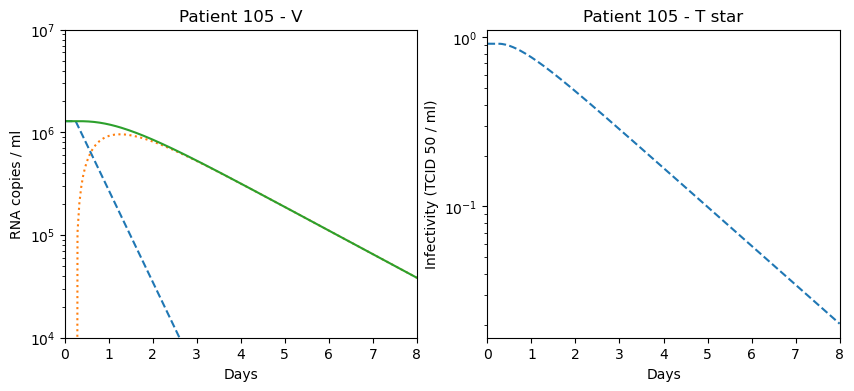

In [16]:
# Answer
# patient 105 - V
fig, axes = plt.subplots(1,2,figsize=(10,4))
vi_105 = sol[:,1]
vni_105 = sol[:,2]
vt_105 = vi_105 + vni_105

axes[0].plot(days_array,vi_105, "--")
axes[0].plot(days_array,vni_105, ":")
axes[0].plot(days_array,vt_105)

axes[0].set_yscale('log')
axes[0].set_xlim(days_array.min(), days_array.max())
axes[0].set_ylim(bottom=1e4, top=1e7)

axes[0].set_title("Patient 105 - V")
axes[0].set_ylabel("RNA copies / ml")
axes[0].set_xlabel("Days")


# patient 105 - T star

T_star_105 = sol[:,0]
axes[1].plot(days_array,T_star_105, "--")
axes[1].set_yscale('log')

axes[1].set_xlim(days_array.min(), days_array.max())
# axes[1].set_ylim(bottom=10, top=1e4)
axes[1].set_xlabel("Days")
axes[1].set_ylabel("Infectivity (TCID 50 / ml)")
axes[1].set_title("Patient 105 - T star")




#### iv. Are the results essentially the same as in (1)?

Show quantitative evidence of your conclusion.

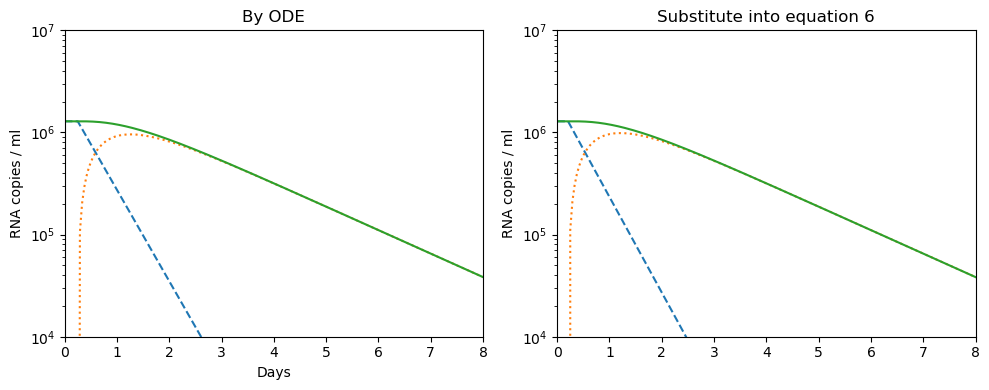

In [17]:
# Answer
# Compare V in two approaches

fig, axes = plt.subplots(1,2,figsize=(10,4))

# 1. by ODE
axes[0].plot(days_array,vi_105, "--")
axes[0].plot(days_array,vni_105, ":")
axes[0].plot(days_array,vt_105)

axes[0].set_yscale('log')
axes[0].set_xlim(days_array.min(), days_array.max())
axes[0].set_ylim(bottom=1e4, top=1e7)

axes[0].set_title("By ODE")
axes[0].set_ylabel("RNA copies / ml")
axes[0].set_xlabel("Days")


# 2. directly using equation 6
vt, vi, vni = equation_6(tps=days_array, 
           v0=V_105, 
           c=c_105, 
           delta = delta_105, 
           delay = delay_105,
           scale = 2)


axes[1].plot(days_array,vi, "--")
axes[1].plot(days_array,vni, ":")
axes[1].plot(days_array,vt)

axes[1].set_yscale('log')
axes[1].set_xlim(days_array.min(), days_array.max())
axes[1].set_ylim(bottom=1e4, top=1e7)

axes[1].set_title("Substitute into equation 6")
axes[1].set_ylabel("RNA copies / ml")

plt.tight_layout()

In [18]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(vt_105, vt)

print("Vt:")
print('Statistic:', statistic)
print('P-value:', p_value)

statistic, p_value = ks_2samp(vi_105, vi)

print("Vi:")
print('Statistic:', statistic)
print('P-value:', p_value)

statistic, p_value = ks_2samp(vni_105, vni)

print("Vni:")
print('Statistic:', statistic)
print('P-value:', p_value)

print("Vt, Vi, Vni shares siginificantly same results since p-value > 0.05 in KS tests")

Vt:
Statistic: 0.0051813471502590676
P-value: 1.0
Vi:
Statistic: 0.05181347150259067
P-value: 0.9586993666059546
Vni:
Statistic: 0.06217616580310881
P-value: 0.8510123863172906
Vt, Vi, Vni shares siginificantly same results since p-value > 0.05 in KS tests


Text(0.5, 1.0, 'Substitute into equation 6')

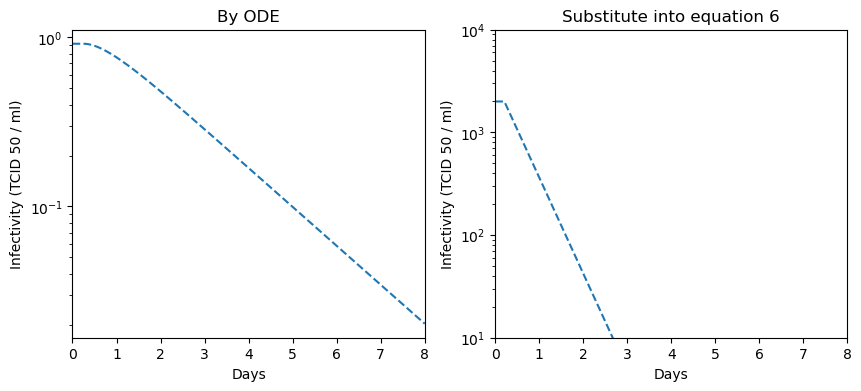

In [19]:
# Answer
# Comparison of T star in two approaches

fig, axes = plt.subplots(1,2,figsize=(10,4))

# 1. by ODE
axes[0].plot(days_array,T_star_105, "--")
axes[0].set_yscale('log')

axes[0].set_xlim(days_array.min(), days_array.max())
axes[0].set_xlabel("Days")
axes[0].set_ylabel("Infectivity (TCID 50 / ml)")
axes[0].set_title("By ODE")


# 2. directly using equation 6
vt, vi, vni = equation_6(tps=days_array, 
           v0=1e3, 
           c=c_105, 
           delta = delta_105, 
           delay = delay_105,
           scale = 2)

axes[1].plot(days_array,vi, "--")
axes[1].set_yscale('log')

axes[1].set_xlim(days_array.min(), days_array.max())
axes[1].set_ylim(bottom=10, top=1e4)
axes[1].set_xlabel("Days")
axes[1].set_ylabel("Infectivity (TCID 50 / ml)")
axes[1].set_title("Substitute into equation 6")

In [20]:
statistic, p_value = ks_2samp(T_star_105, vni)

print("Vni:")
print('Statistic:', statistic)
print('P-value:', p_value)

print("T star shares siginificantly different results since p-value < 0.05 in KS test")

Vni:
Statistic: 0.9689119170984456
P-value: 1.38140305901919e-102
T star shares siginificantly different results since p-value < 0.05 in KS test


### (4) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 1/days and δ=0.5 1/days as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

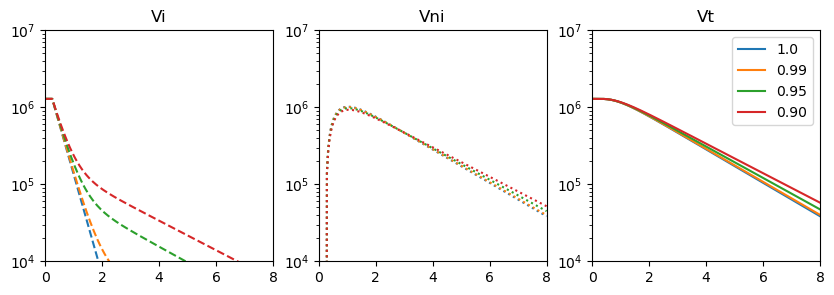

In [244]:
# Answer
sol_list = []

fig, ax = plt.subplots(1,3, figsize=(10,3))
eta_list = [1.0, 0.99, 0.95, 0.90]

# loop via eta list to use ODE solver
for eta in eta_list:
    sol = run_ode_solver(timepoints=days_array, 
               V_i0=patient_vi_t0, 
               k=k, 
               T0=T_105, 
               delta=0.5, 
               c=3.0, 
               eta=eta, 
               delay=delay_105)
    sol_list.append(sol)

    ax[0].set_title("Vi")
    ax[0].plot(days_array, sol[:,1], "--")
    ax[0].set_yscale('log')
    ax[0].set_xlim(days_array.min(), days_array.max())
    ax[0].set_ylim(bottom=1e4, top=1e7)
    
    ax[1].set_title("Vni")
    ax[1].plot(days_array, sol[:,2], ":")
    ax[1].set_yscale('log')
    ax[1].set_xlim(days_array.min(), days_array.max())
    ax[1].set_ylim(bottom=1e4, top=1e7)
    
    ax[2].set_title("Vt")
    ax[2].plot(days_array, sol[:,1]+sol[:,2])
    ax[2].set_yscale('log')
    ax[2].set_xlim(days_array.min(), days_array.max())
    ax[2].set_ylim(bottom=1e4, top=1e7)

plt.legend(['1.0', '0.99', '0.95', '0.90'], loc='upper right')

#### (ii) Then, use the function `scipy.optimize.leastsq` to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss how an imperfect drug would affect the clearance time estimates.

In [245]:
# Answer
from scipy.optimize import least_squares

def equation_6_fit(c, delta, x, v0, scale=2):    
    vt = v0 * np.exp(-c*x) + c*v0 / (c-delta) * (c/(c-delta) * (np.exp(-delta*x) - np.exp(-c*x)) - delta * x * np.exp(-c*x))
    
    vt *= scale
    
    return vt


def residuals(params, v0, delay, x, y):
    # truncate after delayed part 
    x_adj = x[:-int(delay*24)].copy()
    y_adj = y[int(delay*24):].copy()
    c = params[0]
    delta = params[1]
    
    return(y_adj - equation_6_fit(c, delta, x_adj, v0))

    
# Initial guess
params = [3, 0.5]
xdata = days_array

results_list = []
for idx, eta in enumerate(eta_list):
    ydata = sol_list[idx][:,1] + sol_list[idx][:,2] #vt = vi + vni

    # Perform least squares optimization
    result = least_squares(residuals, params, args=(V_105, delay_105, xdata, ydata))

    assert result.success
    results_list.append(result.x)
    
    print(f"eta={eta}: c={result.x[0]},  delta={result.x[1]}")
    

eta=1.0: c=2.999999990207131,  delta=0.5000000005111362
eta=0.99: c=3.002990314781505,  delta=0.4940142992812677
eta=0.95: c=3.0147622105197396,  delta=0.4703509296669052
eta=0.9: c=3.029068979036779,  delta=0.4413725530241637


When the drug effectiveness is not perfect (eta < 1), delta (decay rate of productively infected cells) tends to be smaller with a smaller effectiveness while c tends to be essentially unchanged (only very sight increase). This affects the estimated lifespan of productively infected cells (1/delta) to be larger, and thus affects the clearance time estimates to be larger.